# Recreation of Rust 1987 - Quentin ANDRE

# I. Setting-up the environment

## 1°) Importation of the modules

In [1]:
import pandas as pd
import numpy as np
import random as rnd
import scipy.stats as stats
import scipy.optimize as opt
import json as json
import matplotlib as mpl
from math import exp
from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize
from IPython.display import display
from IPython.core.display import HTML
rnd.seed(2)

## 2°) Styling of the notebook

In [2]:
%matplotlib inline
figsize(15.5, 8)
pd.set_option("display.precision", 3)
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)
s = json.load( open("../styles/bmh_matplotlibrc.json") )
mpl.rcParams.update(s)

def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

# II. Notations and definitions

## 1°) Number of states and state transitions

In this paper, the agent observes each bus at a given time $t$, and makes a decision regarding the replacement of the engine or its maintenance as a function of the observed state of the engine (i.e. its mileage).

As in the original paper, we discretize the number of states into intervals of length 5000, and define a transition density which governs the evolution of mileage from one time period to another: 

$$ p(x_{t+1} | x_{t} , i_{t} , \theta_{3})  = \left\{
  \begin{array}{l l}
    g(x_{t+1} - x_{t}, \theta_{3})   & \quad \text{if } i_t = 0\\
    g(x_{t+1} - 0, \theta_{3}) & \quad \text{if } i_t = 1
  \end{array} \right.$$
  
Here, the function g is defined by a multinomial distribution on the set {0, 1, 2}. In other words, the probability that a bus' mileage will increase by a value x between now and the next maintenance decision is:
* $\theta_{31}$ if $x \in [0, 5000[$
* $\theta_{32}$ if $x \in [5000, 10,000[$
* $\theta_{33} = 1 - (\theta_{31} + \theta_{32})$ if $x \in [10,000, +\infty[$

## 2°) Decision criteria

The utility function of the decision maker for a single time period is:

$$ u(x_{t}, i , \theta_{1})  = \left\{
  \begin{array}{l l}
    \qquad \enspace -c(x_t, \theta_1) + \epsilon_t(0)& \quad \text{if } i = 0\\
    -RC -c(0, \theta_1) + \epsilon_t(1) & \quad \text{if } i = 1
  \end{array} \right. \quad \text{(Errors are I.I.D. standard Gumbel)}$$

The agent will chose the decision which maximizes its utility. If the agent is forward looking (i.e. if $\beta \neq 0$), he does not only maximize his utility in the present time period, but also his future utility discounted by $\beta$.

Since $\beta$ cannot be estimated without knowing the utility function, we will later set $\beta$ to its true value.

## 3°) Cost function

A functional form has to be imposed on the cost function $c(x_t)$. 

In this recreation, we assume that the replacement cost is a constant $\text{RC}$, and allow the maintenance cost $\text{MC}(s, \theta_1)$ to be a linear, exponential or logarithmic function of the state of the bus scaled by a parameter $\theta_1$

# III. Data-generating process

## 1°) Bus Mileage

### A. Introduction

The generation of a fake dataset can be done in two different ways:
* Generating monthly mileage increase from a continuous distribution, discretize the mileage, and recover the state transition parameters ($\theta_3$) using a maximum-likelihood estimation (as done in the paper).
* Set the vector $\theta_3$ to an arbitrary value, and generate discrete states transitions with corresponding probabilities. 

The advantage of the first method is that this is closer to what is actually done in the paper: indeed, the focal goal of the paper is to recover RC and the cost scaling vector of parameters $\theta_1$. 

If the decision of the agent is based on the discretized state (and not on the actual mileage), then this approach is not noisier than the second one.

### B. Mileage Transition Definition
For this reason, we will adopt this first approach, and assumes that the increase in mileage follows a truncated normal distribution bounded at [0, 15000]:

$$
(M_{t+1} - M_{t}) \sim \mathcal{N}_{Trunc}(6000, 4000)
$$

The parameters are arbitrarily chosen to ensure that the state transitions probabilities are plausible:

In [3]:
lower, upper = 0, 15000
mu, sigma = 6000, 4000
mileage_dist = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)

Computing the state transitions probabilities:

In [4]:
p_x0 = mileage_dist.cdf(5000)
p_x1 = mileage_dist.cdf(10000) - p_x0
p_x2 = 1 - p_x1 - p_x0
p = (p_x0, p_x1, p_x2)

Plotting the state transitions probabilities:

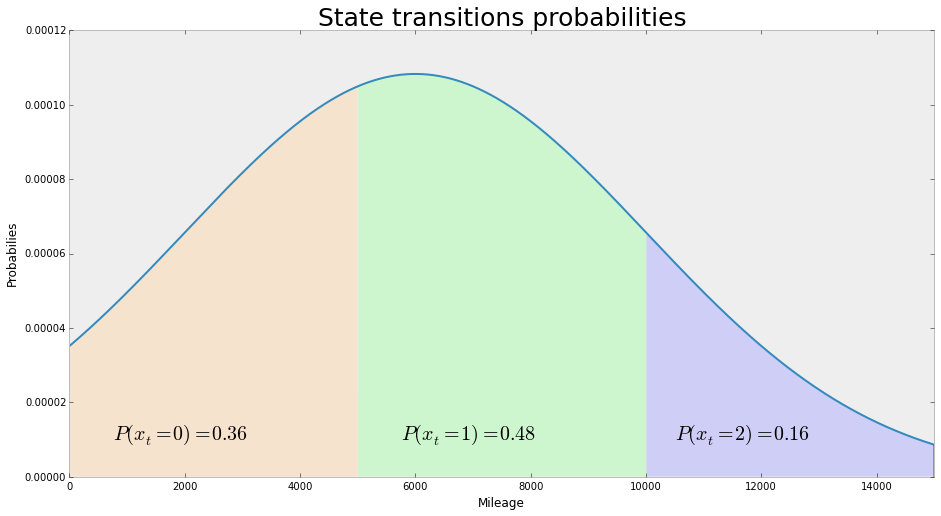

In [5]:
x = np.linspace(0,150001,150001)
y = mileage_dist.pdf(x)
plt.plot(x, y)
plt.title("State transitions probabilities", fontsize=25)
plt.xlabel("Mileage")
plt.ylabel("Probabilies")
plt.text(750, 0.00001, "$P(x_t = 0) = {:.2f}$".format(p_x0), fontsize=20, weight="bold")
plt.text(5750, 0.00001, "$P(x_t = 1) = {:.2f}$".format(p_x1), fontsize=20, weight="bold")
plt.text(10500, 0.00001, "$P(x_t = 2) =  {:.2f}$".format(p_x2), fontsize=20, weight="bold")
plt.fill_between(x, y, where=x>=0, facecolor='#F6E3CE', interpolate=True)
plt.fill_between(x, y, where=x>=5000, facecolor='#CEF6CE', interpolate=True)
plt.fill_between(x, y, where=x>=10000, facecolor='#CECEF6', interpolate=True)
plt.grid(False)
plt.xlim(0, 15000);

Between each inspection, each bus has:
* A probability $P(x_t = 0) =  0.36$ of keeping the same mileage state (between 0 and 5,000 miles traveled)
* A probability $P(x_t = 1) =  0.48$ of increasing its mileage state by 1 (between 5,000 and 10,000 miles traveled) 
* A probability $P(x_t = 2) =  0.16$ of increasing its mileage state by 2 (between 10,000 and 15,000 miles traveled) 

## 2°) Agent's Decisions

### A. Initialization of the variables

The replacement cost, the maintenance cost function parameters, and the discount rate are defined in this section. We set up the discount rate to be lower than in the paper to speed up the convergence of the contraction mapping algorithm.

In [6]:
rc = 20
theta1_1 = 0.5
theta1_2 = 0.01
beta = 0.75

### B. Definition of the cost function

In [7]:
def myopic_costs(S, MF, params, p):
    """
    This function computes the myopic expected cost associated with each decision for each state, 
    and returns an array of state/decision costs.
    
    Takes:
        * An integer S, describing the possible states of the bus
        * A maintenance cost function MF, which takes a vector of parameters and a `state' argument
        * A vector params, to be supplied to the maintenance cost function MF. The first element of 
          the vector is the replacement cost rc.
        * A (3x1) vector p describing the state transitions probabilities 
        
    Returns:
        * A (Nx2) array containing the maintenance and replacement costs for the N possible states of the bus
    """
    rc = params[0]
    maint_cost = [MF(s, params[1:]) for s in range(0, S)]
    repl_cost = [rc for state in range(0, S)]
    return np.vstack((maint_cost, repl_cost)).T

We assume different possible forms for the maintenance cost function:

$$\text{A linear form: } \qquad \text{MF}(s, \theta) = \theta_1 s \\
\text{A quadratic form: } \qquad \text{MF}(s, \theta) = \theta_{1 1}  s + \theta_{1 2}s^2 \\
\text{An exponential form: } \qquad \text{MF}(s, \theta) = \theta_{1 1}\exp(\theta_{1 2}s) \\
\text{A logarithmic form: } \qquad \text{MF}(s, \theta) = \theta_{1 1}\log(\theta_{1 2}s)$$

In [8]:
def lin_cost(s, params):
    try:
        theta1_1, = params
        return s*theta1_1
    except ValueError:
        raise ValueError
        print("Wrong number of parameters specified: expected 2, got {}".format(len(params)))

In [9]:
def quad_cost(s, params):
    try:
        theta1_1, theta1_2 = params
        return s*theta1_1 + (s**2)*theta1_2
    except ValueError:
        raise ValueError
        print("Wrong number of parameters specified: expected 2, got {}".format(len(params)))

In [10]:
def exp_cost(s, params):
    try:
        theta1_1, = params
        return np.exp(s*theta1_1)
    except ValueError:
        raise ValueError
        print("Wrong number of parameters specified: expected 1, got {}".format(len(params)))

In [11]:
def log_cost(s, params):
    try:
        theta1_1, theta1_2 = params
        return np.log(theta1_1 + s*theta1_2)
    except ValueError:
        raise ValueError
        print("Wrong number of parameters specified: expected 2, got {}".format(len(params)))
    

### C. Definition of the choice probabilities, as a function of an array of costs

In [12]:
def choice_prob(cost_array):
    """
    Returns the probability of each choice, conditional on an array of state/decision costs.
    """
    S = cost_array.shape[0]
    cost = cost_array - cost_array.min(1).reshape(S, -1)
    util = np.exp(-cost)
    pchoice = util/(np.sum(util, 1).reshape(S, -1))
    return pchoice

### D. The Contraction Mapping Algorithm (generate the forward-looking choice probabilities)

In [13]:
def contraction_mapping(S, p, MF, params, beta=0.75, threshold=1e-6, suppr_output=False):
    """
    Compute the non-myopic expected value of the agent for each possible decision and each possible 
    state of the bus.
    Iterate until the difference in the previously obtained expected value and the new expected value
    is smaller than a constant.
    Takes:
        * A finite number of states S
        * A state-transition probability vector p = [p(0), p(1), p(2), ..., p(k)] of length k < N
        * A maintenance cost function MF
        * A vector params for the cost function
        * A discount factor beta (optional)
        * A convergence threshold (optional)
    
    Returns:
        * The converged choice probabilities for the forward-looking and myopic agents for each state, 
        conditional on `params'
    """
    achieved = True
    # Initialization of the state-transition matrices: describe the state-transition probabilities
    # if the maintenance cost is incurred, and regenerate the state to 0 if the replacement cost
    # is incurred.
    ST_mat = np.zeros((S, S))
    p = np.array(p) 
    for i in range(S):
        for j, _p in enumerate(p):
            if i + j < S-1:
                ST_mat[i+j][i] = _p
                
            elif i + j == S-1:
                ST_mat[S-1][i] = p[j:].sum()
            else:
                pass
    
    R_mat = np.vstack((np.ones((1, S)),np.zeros((S-1, S))))        
            
    # Initialization of the expected value (which is also the myopic
    # decision cost of the agent). Here, the forward-looking component is initialized at 0.
    k = 0
    EV = np.zeros((S, 2))
    EV_myopic = EV_new = myopic_costs(S, MF, params, p)
    # Contraction mapping loop
    while abs(EV_new-EV).max() > threshold:
        # Store the former expected value
        EV = EV_new 
        # Obtained the probability of maintenance and replacement from the former expected value
        pchoice = choice_prob(EV)
        # Compute the expected cost for each state: Nx1 vector
        ecost = (pchoice*EV).sum(1)
        # Compute the two components of forward-looking utility: In case of maintenance, 
        # utility of future states weighted by transition probabilities. In case of replacement,
        # the future utility is the utility of state 0
        futil_maint = np.dot(ecost, ST_mat)
        futil_repl = np.dot(ecost, R_mat)
        futil = np.vstack((futil_maint, futil_repl)).T
        # Future utility is discounted by beta, and added to the myopic cost. 
        EV_new = EV_myopic + beta*futil
        k += 1
        if k == 1000:
            achieved = False
            break

    if not suppr_output:
        if achieved:
            print("Convergence achieved in {} iterations".format(k))
        else:
            print("CM could not converge! Mean difference = {:.6f}".format((EV_new-EV).mean()))

    return (choice_prob(EV_new), choice_prob(EV_myopic))

# IV. Generation of simulated data (using a linear cost specification)

## 1°) True coefficients

Here, we use the same coefficients as the one described earlier:
* Cost and discount coefficients:
    * $RC = 20$
    * $\theta_{11} = 0.5$
    * $\theta_{12} = 0.01$
    * $\beta = 0.75$
* State transition probabilities: $(\text{Mileage}_{t+1} - \text{Mileage}_{t}) \sim \mathcal{N}_{Trunc}(6000, 4000)$, such that:
    * $P(x_t = 0) =  0.36$ 
    * $P(x_t = 1) =  0.48$
    * $P(x_t = 2) =  0.16$
    
Finally, we assume that there are 70 discrete states for the bus' mileage (i.e. no bus has a mileage greater than 345,000 in the dataset).

## 2°) Choice probabilities, as a function of the bus' state:

Using the Contraction Mapping algorithm implemented earlier, we can obtain the probabibility of maintenance as a function of the bus' state for a forward-looking agent and a myopic agent.

In [14]:
params_lin = (rc, theta1_1)
p = (p_x0, p_x1, p_x2)
lin_forward, lin_myopic = contraction_mapping(S=70, p=p, MF=lin_cost, params=params_lin, beta = 0.75)
pchoice = lin_forward.T[0]

Convergence achieved in 54 iterations


Plotting the choice probabilities of the Agents:

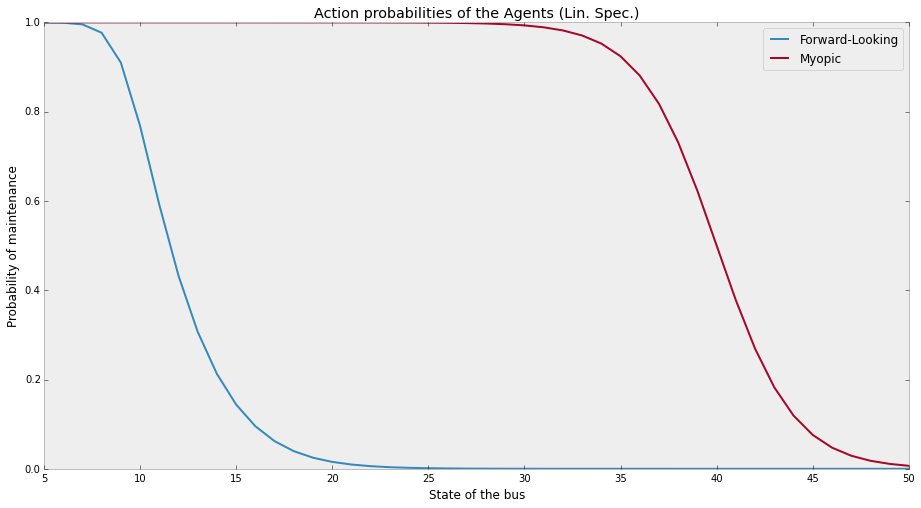

In [15]:
plt.plot(lin_forward.T[0])
plt.plot(lin_myopic.T[0])
plt.ylabel("Probability of maintenance")
plt.xlabel("State of the bus")
plt.legend(["Forward-Looking", "Myopic"])
plt.xlim(5, 50)
plt.title("Action probabilities of the Agents (Lin. Spec.)");

## 3°) The bus replacement dataset.

### A. Initialization
First, we decide on a number of bus, that we initialize in state 0. 

We treat the dataset as an N_Bus x 4 array, containing:
* The identifier of the buses
* The choice made for the buses at this time
* The mileage
* The states

In [16]:
n_bus = 1000
bus_array = np.hstack((np.linspace(1, n_bus, n_bus).reshape(-1, 1), np.zeros((n_bus, 3))))

### B. State transition functions

The dataset of buses transition from one period to another in the following way:
* The agent observes the current state of the buses, and take a decision to maintain (0) or replace (1) each bus.*


* The mileage of each bus is updated a first time:
    * Kept at its current value if the agent decided to maintain the engine
    * Reset to 0 if the agent decided to replace the engine
    
    
* The mileage of each bus is updated a second time : a random draw is taken from the mileage increment random variable for each bus, and the corresponding mileage is added to the mileage of the bus.


* The state of each bus is updated to reflect its new mileage

We define below the transition function and the decision function

In [17]:
def decide(s, pchoice):
    """
    Make a decision to maintain or replace the bus, based on a probability of choice p
    and a current state s
    """
    return np.random.choice([0, 1], p=[pchoice[s], 1-pchoice[s]])

def transition(bus_array, p):
    """
    Return the updated bus dataset after one decision of our agent.
    Takes:
        * bus_array : An array of buses, containing the identifier of the buses, their mileages, and their current
                        state.
        * pchoice : The converged choice probabities of the agent making the decision

    Returns:
        * The updated dataset of buses, with the new decisions appended at the end of the dataframe.
    """
    # Recovering the number of buses, the previous mileage and the previous states of the buses
    n_bus = bus_array[:, 0].max()
    prev_mileage = bus_array[-n_bus:, 2]
    prev_states = bus_array[-n_bus:, 3]
    # Generating choices from choice probabilities, conditional on the state of each bus
    choices = np.array([decide(x, pchoice) for x in prev_states])
    
    # Generating the new mileage and state
    new_mileage = (1-choices)*prev_mileage + mileage_dist.rvs(size=n_bus)
    new_states = np.floor(new_mileage/5000)
    new_array = np.vstack((bus_array[-n_bus:, 0], np.zeros(n_bus), new_mileage, new_states))
    bus_array[-n_bus:,1] = choices 
    return np.vstack((bus_array, new_array.T))

### C. Generation of the full dataset

The complete dataset is generated by making the agent take a serie of decisions. Here, we assume that the agent takes 1000 consecutive decisions. The total number of data points thus generated will be equal to 100,000 (1000 buses and 100 time periods).

In [18]:
n_periods = 100

In [19]:
for i in range(n_periods):
    bus_array = transition(bus_array, pchoice)

Finally, the array is stored into a Dataframe, to make plot and data exports more convenient.

In [20]:
lin_dataframe = pd.DataFrame(bus_array, columns=["Identifier", "Choice", "Mileage", "State"])

### C. Plot of the data

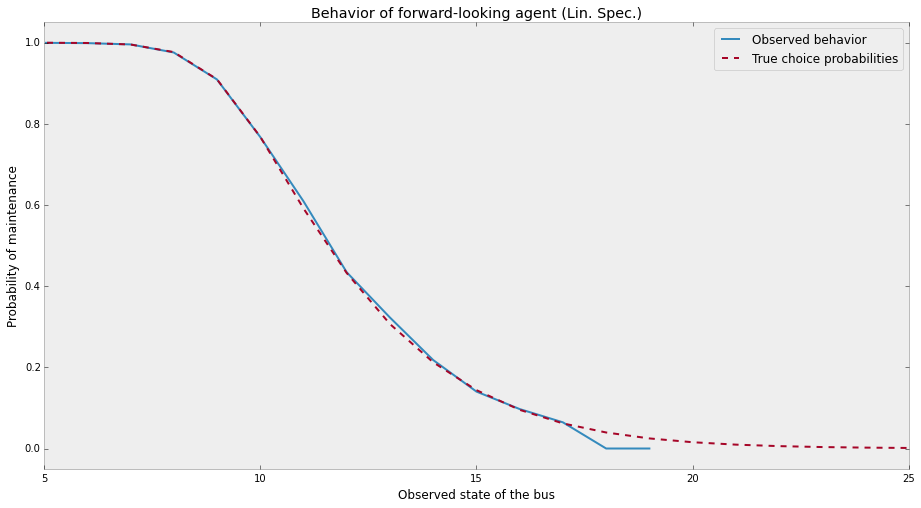

In [21]:
choice_freq = lin_dataframe.loc[:, ["Choice", "State"]].groupby(["State"]).mean().sort().reset_index()
plt.plot(choice_freq["State"], 1-choice_freq["Choice"])
plt.plot(pchoice, "--")
plt.xlabel("Observed state of the bus")
plt.ylabel("Probability of maintenance")
plt.legend(["Observed behavior", "True choice probabilities"])
plt.title("Behavior of forward-looking agent (Lin. Spec.)")
plt.xlim(5, 25)
plt.ylim(-0.05, 1.05);

### C. Export of the data

We only keep the decision state and the choice, as the other variables will not be used in the estimation section.

In [22]:
lin_dataframe.loc[n_bus+1:,["Choice", "State"]].to_csv("Datasets\Lin_Dataset.csv", index=False)

# V. Generation of simulated data (using other cost specifications)

## 1°) Quadratic form

Convergence achieved in 54 iterations


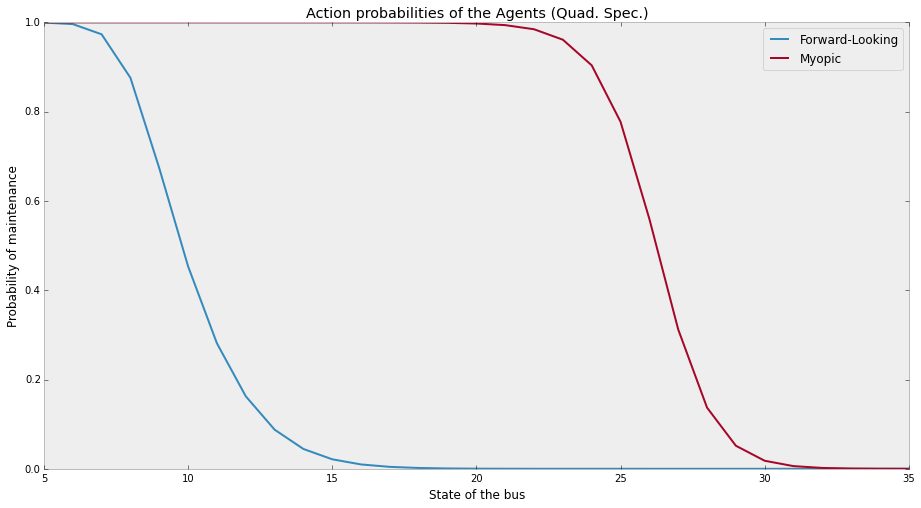

In [23]:
params_quad = (rc, theta1_1, theta1_2)
p = (p_x0, p_x1, p_x2)
quad_forward, quad_myopic = contraction_mapping(S=70, p=p, MF=quad_cost, params=params_quad, beta = 0.75)
pchoice = quad_forward.T[0]
plt.plot(quad_forward.T[0])
plt.plot(quad_myopic.T[0])
plt.ylabel("Probability of maintenance")
plt.xlabel("State of the bus")
plt.legend(["Forward-Looking", "Myopic"])
plt.xlim(5, 35)
plt.title("Action probabilities of the Agents (Quad. Spec.)");

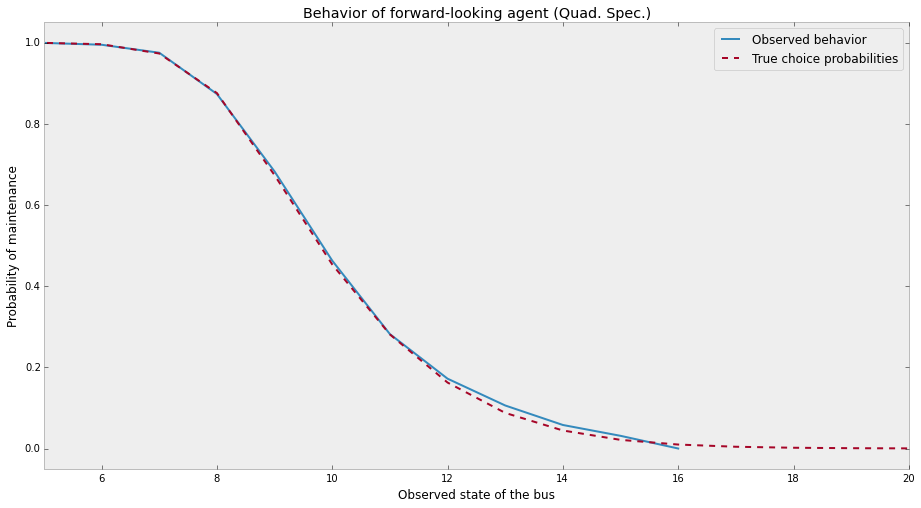

In [24]:
n_bus = 1000
bus_array = np.hstack((np.linspace(1, n_bus, n_bus).reshape(-1, 1), np.zeros((n_bus, 3))))
for i in range(n_periods):
    bus_array = transition(bus_array, pchoice)
quad_dataframe = pd.DataFrame(bus_array, columns=["Identifier", "Choice", "Mileage", "State"])
choice_freq = quad_dataframe.loc[:, ["Choice", "State"]].groupby(["State"]).mean().sort().reset_index()
plt.plot(choice_freq["State"], 1-choice_freq["Choice"])
plt.plot(pchoice, "--")
plt.xlabel("Observed state of the bus")
plt.ylabel("Probability of maintenance")
plt.legend(["Observed behavior", "True choice probabilities"])
plt.title("Behavior of forward-looking agent (Quad. Spec.)")
plt.xlim(5, 20)
plt.ylim(-0.05, 1.05);
quad_dataframe.loc[n_bus+1:,["Choice", "State"]].to_csv("Datasets\Quad_Dataset.csv", index=False)

## 2°) Exponential Form (other parameters for scaling)

Convergence achieved in 55 iterations


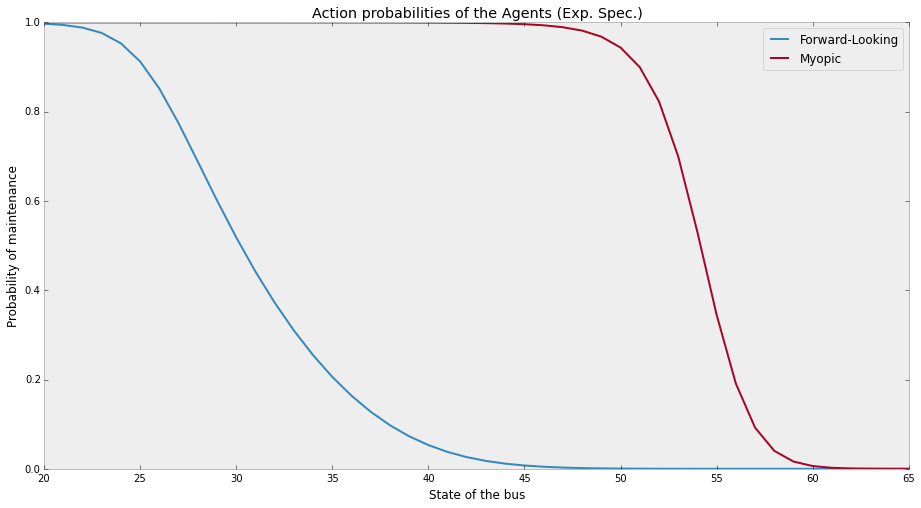

In [25]:
params_exp = (15, 0.05)
p = (p_x0, p_x1, p_x2)
exp_forward, exp_myopic = contraction_mapping(S=70, p=p, MF=exp_cost, params=params_exp, beta = 0.75)
pchoice = exp_forward.T[0]
plt.plot(exp_forward.T[0])
plt.plot(exp_myopic.T[0])
plt.ylabel("Probability of maintenance")
plt.xlabel("State of the bus")
plt.legend(["Forward-Looking", "Myopic"])
plt.xlim(20, 65)
plt.title("Action probabilities of the Agents (Exp. Spec.)");

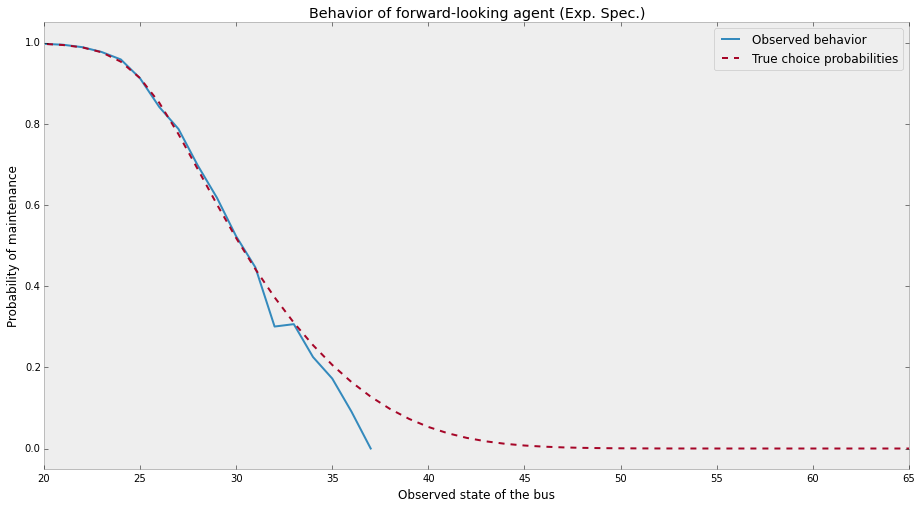

In [26]:
n_bus = 1000
bus_array = np.hstack((np.linspace(1, n_bus, n_bus).reshape(-1, 1), np.zeros((n_bus, 3))))
for i in range(n_periods):
    bus_array = transition(bus_array, pchoice)
exp_dataframe = pd.DataFrame(bus_array, columns=["Identifier", "Choice", "Mileage", "State"])
choice_freq = exp_dataframe.loc[:, ["Choice", "State"]].groupby(["State"]).mean().sort().reset_index()
plt.plot(choice_freq["State"], 1-choice_freq["Choice"])
plt.plot(pchoice, "--")
plt.xlabel("Observed state of the bus")
plt.ylabel("Probability of maintenance")
plt.legend(["Observed behavior", "True choice probabilities"])
plt.title("Behavior of forward-looking agent (Exp. Spec.)")
plt.xlim(20, 65)
plt.ylim(-0.05, 1.05);
exp_dataframe.loc[n_bus+1:,["Choice", "State"]].to_csv("Datasets\Exp_Dataset.csv", index=False)

## 2°) Log Form (other parameters for scaling)

Convergence achieved in 51 iterations


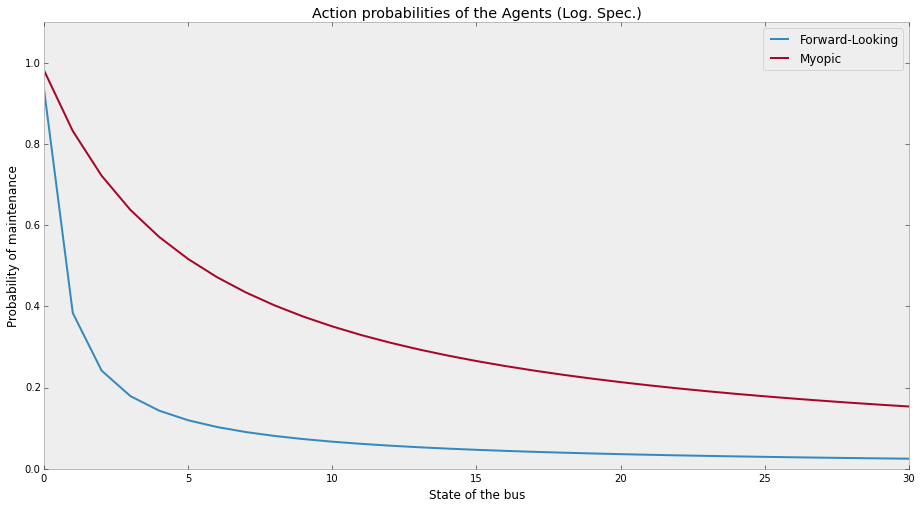

In [27]:
params_log = (4, 1, 10)
p = (p_x0, p_x1, p_x2)
log_forward, log_myopic = contraction_mapping(S=70, p=p, MF=log_cost, params=params_log, beta = 0.75)
pchoice = log_forward.T[0]
plt.plot(log_forward.T[0])
plt.plot(log_myopic.T[0])
plt.ylabel("Probability of maintenance")
plt.xlabel("State of the bus")
plt.legend(["Forward-Looking", "Myopic"])
plt.xlim(0, 30)
plt.ylim(0, 1.1)
plt.title("Action probabilities of the Agents (Log. Spec.)");

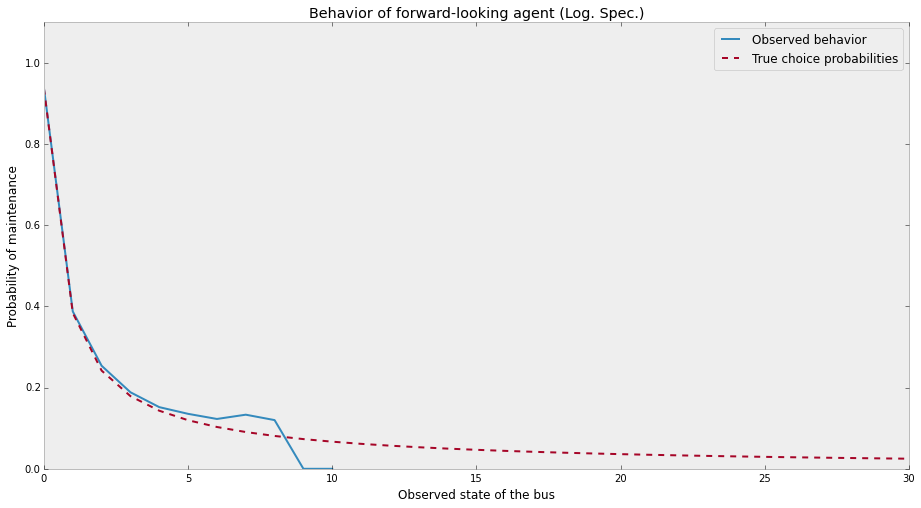

In [28]:
n_bus = 1000
bus_array = np.hstack((np.linspace(1, n_bus, n_bus).reshape(-1, 1), np.zeros((n_bus, 3))))
for i in range(n_periods):
    bus_array = transition(bus_array, pchoice)
log_dataframe = pd.DataFrame(bus_array, columns=["Identifier", "Choice", "Mileage", "State"])
choice_freq = log_dataframe.loc[:, ["Choice", "State"]].groupby(["State"]).mean().sort().reset_index()
plt.plot(choice_freq["State"], 1-choice_freq["Choice"])
plt.plot(pchoice, "--")
plt.xlabel("Observed state of the bus")
plt.ylabel("Probability of maintenance")
plt.legend(["Observed behavior", "True choice probabilities"])
plt.title("Behavior of forward-looking agent (Log. Spec.)")
plt.xlim(0, 30)
plt.ylim(0, 1.1);
log_dataframe.loc[n_bus+1:,["Choice", "State"]].to_csv("Datasets\Log_Dataset.csv", index=False)

# VI. Estimation

## 1°) Dynamic Utility Logit Model

In this section, we implement a Dynamic Utility Logit model, which will be our workbench for the estimation of the data. We wrap in this class the functions defined earlier (to avoid global references) and refactor some portions of the code (to make the model more flexible). The maintenance cost function is kept outside of the scope of the class, and must be supplied at the initialization of the object as an argument.

In [29]:
class DynamicLogit(object):
    def __init__(self, data, Y, X, p, MF, npars):
        """
        A statistics workbench used to evaluate the cost parameters underlying 
        a bus replacement pattern by a forward-looking agent.
        
        Takes:
            * Data: a Pandas dataframe, which contains:
                -Y: the name of the column containing the dummy exogenous 
                    variable (here, the choice)
                -X: the name of the column containing the endogenous variable 
                    (here, the state of the bus)

            * p: The state-transition vector of endogenous variable.
                    For instance, p = [0, 0.6, 0.4] means that the bus will 
                    transition to the next mileage state with probability 0.6, 
                    and to the second next mileage state with probability 0.4.

            * MF: A function passed as an argument, which is the functional 
                  form for the maintenance cost. This function must accept as
                  a first argument a state s, and as a second argument a vector
                  of parameters.
                  
            * npars: The number of parameters to evalutate (i.e. the number of 
                     parameters of the maintenance cost function, plus 1 for
                     the replacement cost)
        """        

        self.endog = data.loc[:, Y].values
        self.exog = data.loc[:, X].values
        
        self.N = self.endog.shape[0]
        self.S = int(self.exog.max()*2) # Assumes that the true maximum number 
                                         # states is twice the maximum observed
                                         # state.
        
        
        # Check that p is a correct vector of probabilities (i.e. sums to 1)
        p = np.array(p)        
        if p.sum() == 1:
            self.p = p
        else:
            raise ValueError(("The probability of state transitions should add" 
                              " up to 1!"))
        
        
        # Check that the stated number of parameters correspond to the
        # specifications of the maintenance cost function.       
        try:
            MF(1, [0]*(npars-1))
        except ValueError:
            raise ValueError(("The number of parameters specified does not "
                              "match the specification of the maintenance cost"
                              " function!"))
        else:
            self.MF = MF
            self.npars = npars
        
        
              
        # To speed up computations and avoid loops when computing the log 
        # likelihood, we create a few useful matrices here:
        S = self.S
        
        # A (SxN) matrix indicating the state of each observation
        self.state_mat = np.array([[self.exog[i]==s for i in range(self.N)] 
                                                    for s in range(self.S)])
        
        # A (SxS) matrix indicating the probability of a bus transitioning
        # from a state s to a state s' (used to compute maintenance utility)
        
        self.trans_mat = np.zeros((S, S))
        for i in range(S):
            for j, _p in enumerate(self.p):
                if i + j < S-1:
                    self.trans_mat[i+j][i] = _p
                elif i + j == S-1:
                    self.trans_mat[S-1][i] = p[j:].sum()
                else:
                    pass

        # A second (SxS) matrix which regenerates the bus' state to 0 with
        # certainty (used to compute the replacement utility)
        self.regen_mat = np.vstack((np.ones((1, S)),np.zeros((S-1, S))))
        
        # A (2xN) matrix indicating with a dummy the decision taken by the agent
        # for each time/bus observation (replace or maintain)
        self.dec_mat = np.vstack(((1-self.endog), self.endog))
    
    def myopic_costs(self, params):
        S = self.S
        """
        This function computes the myopic expected cost associated with each 
        decision for each state.
        
        Takes:
            * A vector params, to be supplied to the maintenance cost function 
              MF. The first element of the vector is the replacement cost rc.

        Returns:
            * A (Sx2) array containing the maintenance and replacement costs 
              for the S possible states of the bus
        """
        rc = params[0]
        thetas = params[1:]
        maint_cost = [self.MF(s, thetas) for s in range(0, S)]
        repl_cost = [rc for state in range(0, S)]
        return np.vstack((maint_cost, repl_cost)).T
    
    def fl_costs(self, params, beta=0.75, threshold=1e-6, suppr_output=False):
        """
        Compute the non-myopic expected value of the agent for each possible 
        decision and each possible state of the bus, conditional on a vector of 
        parameters and on the maintenance cost function specified at the 
        initialization of the DynamicUtility model.

        Iterates until the difference in the previously obtained expected value 
        and the new expected value is smaller than a constant.
        
        Takes:
            * A vector params for the cost function
            * A discount factor beta (optional)
            * A convergence threshold (optional)
            * A boolean argument to suppress the output (optional)

        Returns:
            * An (Sx2) array of forward-looking costs associated with each
              sate and each decision.
        """
        achieved = True
        # Initialization of the contraction mapping
        k = 0
        EV = np.zeros((self.S, 2))
        self.EV_myopic = EV_new = self.myopic_costs(params)
        
        # Contraction mapping Loop
        while abs(EV_new-EV).max() > threshold:
            EV = EV_new 
            pchoice = self.choice_prob(EV)
            ecost = (pchoice*EV).sum(1)
            futil_maint = np.dot(ecost, self.trans_mat)
            futil_repl = np.dot(ecost, self.regen_mat)
            futil = np.vstack((futil_maint, futil_repl)).T
            
            EV_new = self.EV_myopic + beta*futil
            k += 1
            if k == 1000:
                achieved = False
                break

        # Output:
        if not suppr_output:
            if achieved:
                print("Convergence achieved in {} iterations".format(k))
            else:
                print("CM could not converge! Mean difference = {:.6f}".format(
                                                            (EV_new-EV).mean())
                                                                              )
                
        self.EV_FL = EV_new
        return EV

    def choice_prob(self, cost_array):
        """
        Returns the probability of each choice for each observed state, 
        conditional on an array of state/decision costs (generated by the 
        myopic or forward-looking cost functions)
        """
        cost = cost_array - cost_array.min(1).reshape(self.S, -1)
        util = np.exp(-cost)
        pchoice = util/(np.sum(util, 1).reshape(self.S, -1))
        return pchoice
        
    def loglike(self, params):
        """
        The log-likelihood of the Dynamic model is estimated in several steps.
        1°) The currenter parameters are supplied to the contraction mapping 
            function
        2°) The function returns a matrix of decision probabilities for each 
            state.
        3°) This matrix is used to compute the loglikelihood of the 
            observations
        4°) The log-likelihood are then summed accross individuals, and 
            returned
        """
        util = self.fl_costs(params, suppr_output=True) 
        pchoice = self.choice_prob(util) 
        logprob = np.log(np.dot(pchoice.T, self.state_mat))
        return -np.sum(self.dec_mat*logprob)
    
    def fit_likelihood(self, x0=None, bounds=None):
        """
        Fit the parameters to the data.
        """
        if bounds == None:
            bounds = [(1e-6, None) for i in range(self.npars)]
            
        if x0 == None:
            x0 = [0.1 for i in range(self.npars)]
            
        self.fitted = opt.fmin_l_bfgs_b(self.loglike, x0=x0, approx_grad=True, 
                                        bounds=bounds)
    
    
    def get_parameters(self):
        """
        Return the parameters obtained after fitting the likelihood function
        to the data.
        """
        return self.fitted[0]
        
    def print_parameters(self):
        loglike =  self.fitted[1]
        fit_params = self.get_parameters()
        RC, thetas = fit_params[0], fit_params[1:]
        logstring = "Log-likelihood = {0:.2f}".format(loglike)
        thetas_string = ["theta1_{0} = {1:.4f}".format(i+1, t) \
                                                for i, t in enumerate(thetas)]
        thetas_string = ", ".join(thetas_string)
        rc_string = "Parameters: RC = {0:.4f}".format(RC)
        print(logstring, rc_string + ", " + thetas_string)

 

## 2°) Fitting the linear cost data

In this section, we fit the data generated by the linear cost function and recover the parameters $\text{RC}$ and $\theta$. We do it for different characterizations of the cost function, and thereby illustrate the consequences of a misspecification.

Recall that in the linear model:

$$\text{RC} = 20$$

$$\theta_{11} = 0.5$$

### A. Fitting the true linear cost function to the data
We start by initializing a DynamicLogit instance, and fit the likelihood function to the data. 

In [30]:
lin_to_lin = DynamicLogit(lin_dataframe, "Choice", "State", p, lin_cost, npars=2)
lin_to_lin.fit_likelihood()

The results:

In [31]:
lin_to_lin.print_parameters()

Log-likelihood = 16318.95 Parameters: RC = 19.5047, theta1_1 = 0.4847


In [32]:
lin_forward_app, lin_myopic_app = contraction_mapping(S=70, p=p, 
                                                      MF=lin_cost, params=lin_to_lin.get_parameters(), 
                                                      beta = 0.75)

Convergence achieved in 54 iterations


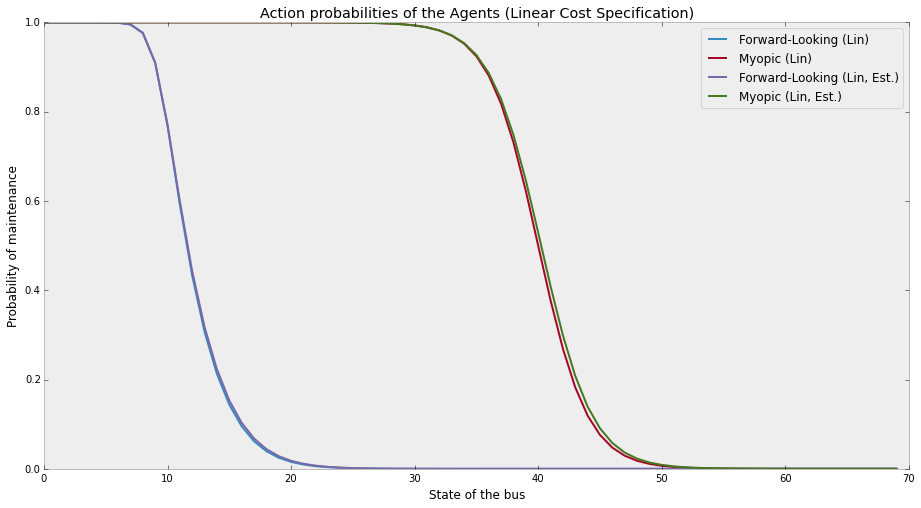

In [33]:
plt.plot(lin_forward.T[0])
plt.plot(lin_myopic.T[0])
plt.plot(lin_forward_app.T[0])
plt.plot(lin_myopic_app.T[0])
plt.ylabel("Probability of maintenance")
plt.xlabel("State of the bus")
plt.legend(["Forward-Looking (Lin)", "Myopic (Lin)", "Forward-Looking (Lin, Est.)", "Myopic (Lin, Est.)", ])
plt.xlim(0, 70)
plt.title("Action probabilities of the Agents (Linear Cost Specification)");

### B. Fitting an incorrect quadratic cost model to the data

We initialize a second DynamicLogit instance, this time with our quadratic cost specification

In [34]:
quad_to_lin = DynamicLogit(lin_dataframe, "Choice", "State", p, quad_cost, npars=3)
quad_to_lin.fit_likelihood()

The results:

In [35]:
quad_to_lin.print_parameters()

Log-likelihood = 16318.58 Parameters: RC = 18.6141, theta1_1 = 0.4281, theta1_2 = 0.0027


The optimization procedures correctly brings $\theta_{12}$ to 0. As a consequence, this specification fits the data perfectly.

In [36]:
quad_forward_app, quad_myopic_app = contraction_mapping(S=70, p=p, 
                                                      MF=quad_cost, params=quad_to_lin.get_parameters(), 
                                                      beta = 0.75)

Convergence achieved in 54 iterations


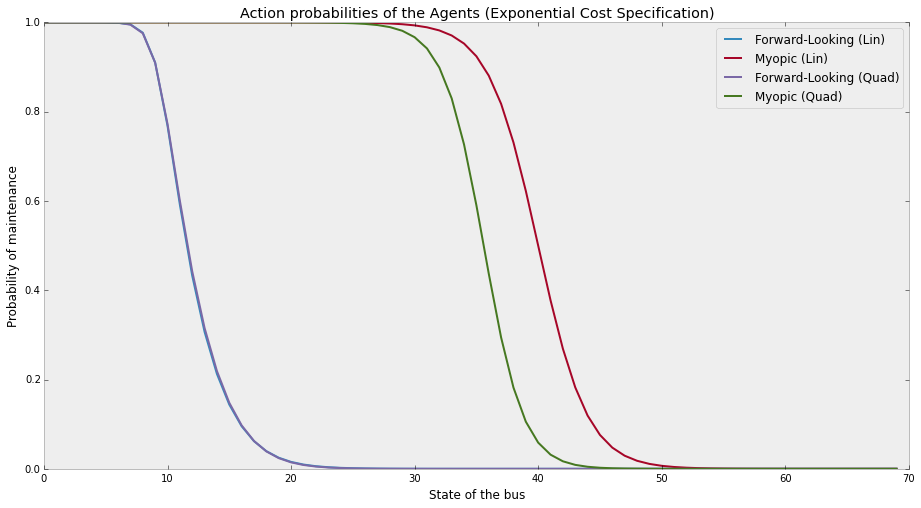

In [37]:
plt.plot(lin_forward.T[0])
plt.plot(lin_myopic.T[0])
plt.plot(quad_forward_app.T[0])
plt.plot(quad_myopic_app.T[0])
plt.ylabel("Probability of maintenance")
plt.xlabel("State of the bus")
plt.legend(["Forward-Looking (Lin)", "Myopic (Lin)", "Forward-Looking (Quad)", "Myopic (Quad)"])
plt.xlim(0, 70)
plt.title("Action probabilities of the Agents (Exponential Cost Specification)");

### C. Fitting an incorrect exponential cost model to the data

We initialize a third DynamicLogit instance, this time with our exponential cost specification

In [38]:
exp_to_lin = DynamicLogit(lin_dataframe, "Choice", "State", p, exp_cost, npars=2)
exp_to_lin.fit_likelihood(bounds=[(0, None), (0.1, None)])

The results:

In [39]:
exp_to_lin.print_parameters()

Log-likelihood = 16361.21 Parameters: RC = 13.3755, theta1_1 = 0.1254


The myopic choice probabilities look different, but the forward-looking ones fit the data quite well.

In [40]:
exp_forward_app, exp_myopic_app = contraction_mapping(S=70, p=p, 
                                                      MF=exp_cost, params=exp_to_lin.get_parameters(), 
                                                      beta = 0.75)

Convergence achieved in 53 iterations


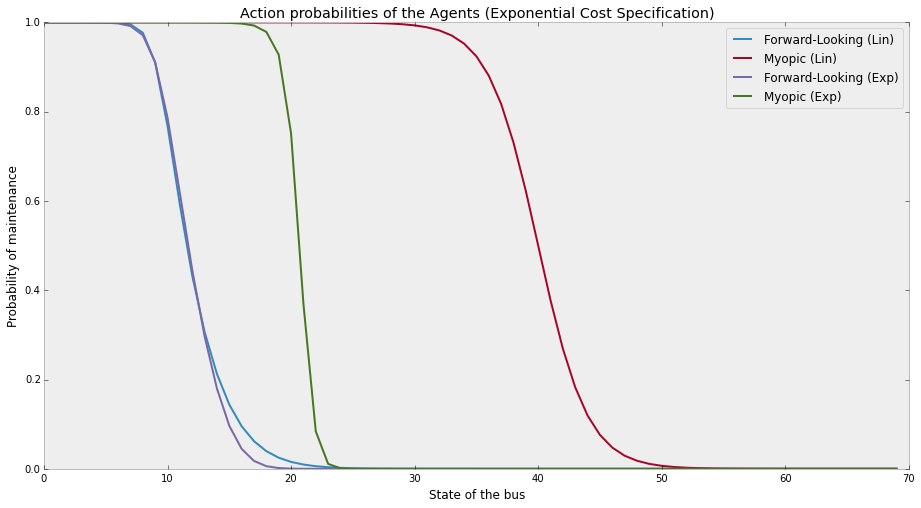

In [41]:
plt.plot(lin_forward.T[0])
plt.plot(lin_myopic.T[0])
plt.plot(exp_forward_app.T[0])
plt.plot(exp_myopic_app.T[0])
plt.ylabel("Probability of maintenance")
plt.xlabel("State of the bus")
plt.legend(["Forward-Looking (Lin)", "Myopic (Lin)", "Forward-Looking (Exp)", "Myopic (Exp)"])
plt.xlim(0, 70)
plt.title("Action probabilities of the Agents (Exponential Cost Specification)");

### D. Fitting an incorrect log cost function to the data.

We initialize a fourth DynamicLogit instance, this time with our log cost specification

In [42]:
log_to_lin = DynamicLogit(lin_dataframe, "Choice", "State", p, log_cost, npars=3)
log_to_lin.fit_likelihood(x0=[10, 10, 10])

The results:

In [43]:
log_to_lin.print_parameters()

Log-likelihood = 20419.18 Parameters: RC = 23.7303, theta1_1 = 0.0031, theta1_2 = 46.6191


In [44]:
log_forward_app, log_myopic_app = contraction_mapping(S=70, p=p, MF=log_cost, 
                                                      params=log_to_lin.get_parameters(), beta = 0.75)

Convergence achieved in 56 iterations


In this case, both the myopic and forward looking choice probabilities are very different from the true ones.

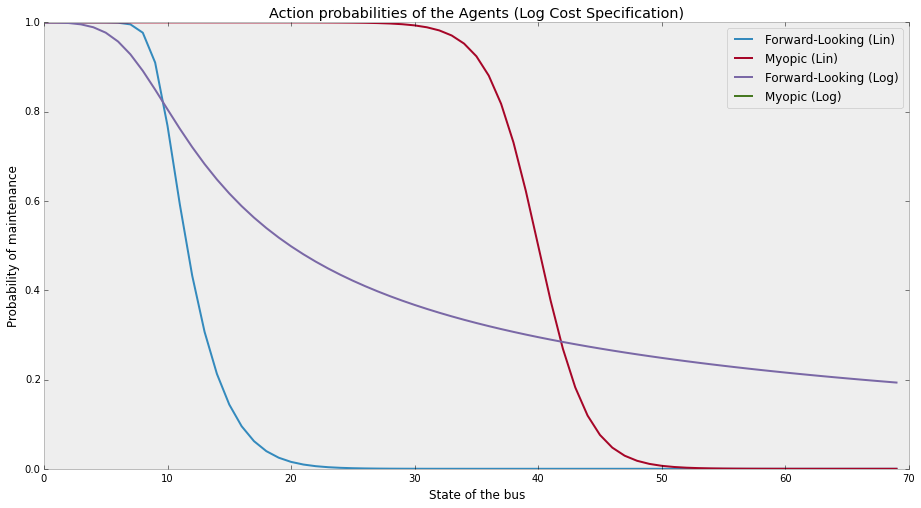

In [45]:
plt.plot(lin_forward.T[0])
plt.plot(lin_myopic.T[0])
plt.plot(log_forward_app.T[0])
plt.plot(log_myopic_app.T[0])
plt.ylabel("Probability of maintenance")
plt.xlabel("State of the bus")
plt.legend(["Forward-Looking (Lin)", "Myopic (Lin)", "Forward-Looking (Log)", "Myopic (Log)"])
plt.xlim(0, 70)
plt.title("Action probabilities of the Agents (Log Cost Specification)");

## 2°) Fitting the other cost data

In this section, we fit the data generated by the quadratic, exponential, and logarithmic cost function and recover the parameters $\text{RC}$ and $\theta_{11}$ and $\theta_{12}$. We do not illustrate the impact of misspecification for those cost functions.

### A. Fitting the true quadratic cost function
We start by initializing a DynamicLogit instance, and fit the likelihood function to the data. 

Recall that in the quadratic model:

$$\text{RC} = 20$$

$$\theta_{11} = 0.5$$

$$\theta_{12} = 0.01$$

In [46]:
quad_to_quad = DynamicLogit(quad_dataframe, "Choice", "State", p, quad_cost, npars=3)
quad_to_quad.fit_likelihood(x0=[20, 1, 1])

The results:

In [47]:
quad_to_quad.print_parameters()

Log-likelihood = 16767.50 Parameters: RC = 18.7804, theta1_1 = 0.4277, theta1_2 = 0.0129


In [48]:
quad_forward_app, quad_myopic_app = contraction_mapping(S=70, p=p, MF=quad_cost, 
                                                      params=quad_to_quad.get_parameters(), beta = 0.75)

Convergence achieved in 54 iterations


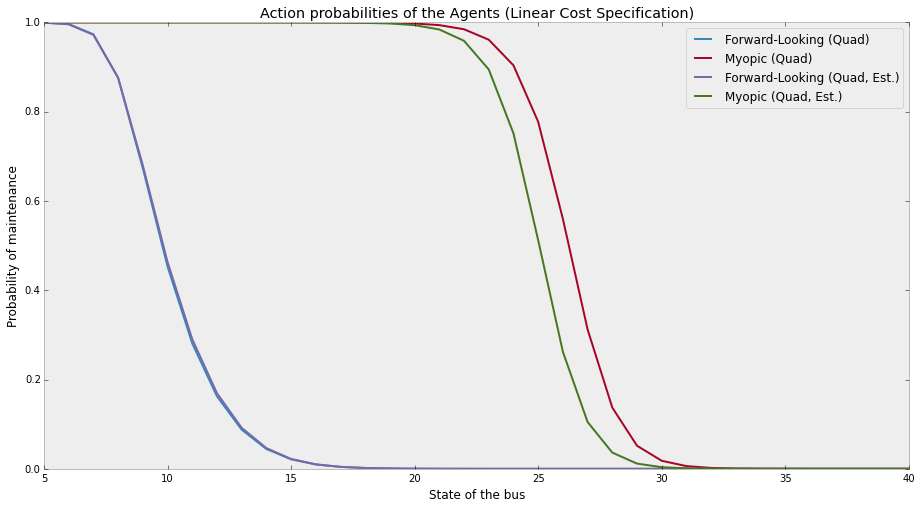

In [49]:
plt.plot(quad_forward.T[0])
plt.plot(quad_myopic.T[0])
plt.plot(quad_forward_app.T[0])
plt.plot(quad_myopic_app.T[0])
plt.ylabel("Probability of maintenance")
plt.xlabel("State of the bus")
plt.legend(["Forward-Looking (Quad)", "Myopic (Quad)", "Forward-Looking (Quad, Est.)", "Myopic (Quad, Est.)"])
plt.xlim(5, 40)
plt.title("Action probabilities of the Agents (Linear Cost Specification)");

### B. Fitting the exponential cost function

Recall that in the exponential model:

$$\text{RC} = 15$$

$$\theta_{11} = 0.05$$

In [50]:
exp_to_exp = DynamicLogit(exp_dataframe, "Choice", "State", p, exp_cost, npars=2)
exp_to_exp.fit_likelihood()

The results:

In [51]:
exp_to_exp.print_parameters()

Log-likelihood = 8404.00 Parameters: RC = 15.0868, theta1_1 = 0.0501


In [52]:
exp_forward_app, exp_myopic_app = contraction_mapping(S=70, p=p, MF=exp_cost, 
                                                      params=exp_to_exp.get_parameters(), beta = 0.75)

Convergence achieved in 55 iterations


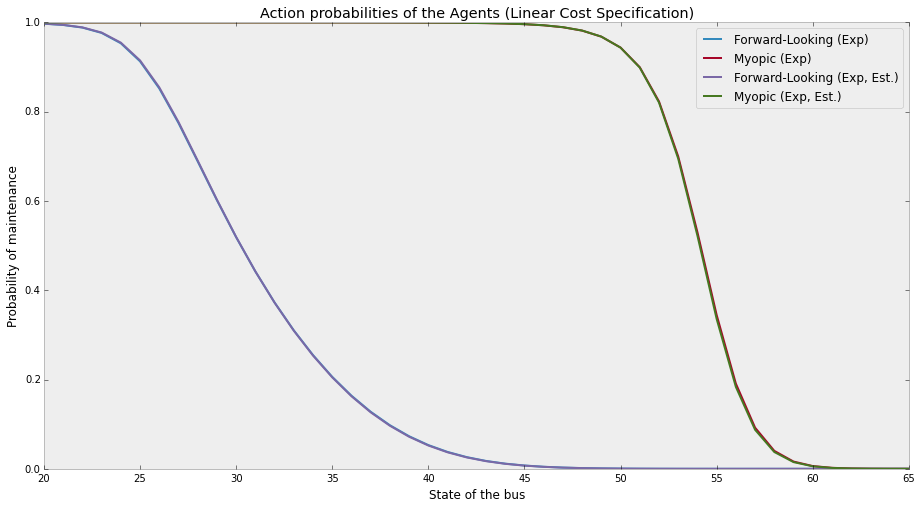

In [53]:
plt.plot(exp_forward.T[0])
plt.plot(exp_myopic.T[0])
plt.plot(exp_forward_app.T[0])
plt.plot(exp_myopic_app.T[0])
plt.ylabel("Probability of maintenance")
plt.xlabel("State of the bus")
plt.legend(["Forward-Looking (Exp)", "Myopic (Exp)", "Forward-Looking (Exp, Est.)", "Myopic (Exp, Est.)"])
plt.xlim(20, 65)
plt.title("Action probabilities of the Agents (Linear Cost Specification)");

### C. Fitting the logarithmic cost function

Recall that in the logarithmic model:

$$\text{RC} = 4$$

$$\theta_{11} = 1$$

$$\theta_{12} = 10$$

In [54]:
log_to_log = DynamicLogit(log_dataframe, "Choice", "State", p, log_cost, npars=3)
log_to_log.fit_likelihood()

The results:

In [55]:
log_to_log.print_parameters()

Log-likelihood = 51648.30 Parameters: RC = 0.5309, theta1_1 = 0.0306, theta1_2 = 0.2968


The parameters look different from the one used to generate the data...

In [56]:
log_forward_app, log_myopic_app = contraction_mapping(S=70, p=p, MF=log_cost, 
                                                      params=log_to_log.get_parameters(), beta = 0.75)

Convergence achieved in 50 iterations


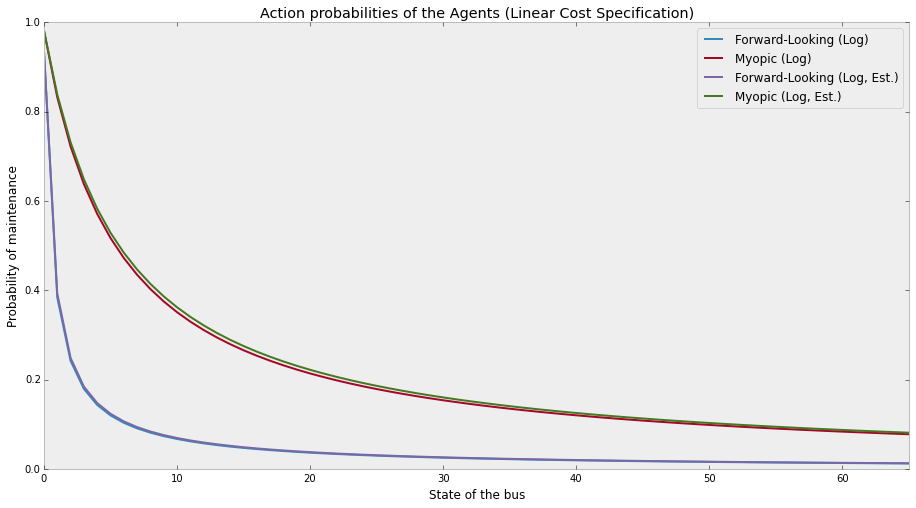

In [57]:
plt.plot(log_forward.T[0])
plt.plot(log_myopic.T[0])
plt.plot(log_forward_app.T[0])
plt.plot(log_myopic_app.T[0])
plt.ylabel("Probability of maintenance")
plt.xlabel("State of the bus")
plt.legend(["Forward-Looking (Log)", "Myopic (Log)", "Forward-Looking (Log, Est.)", "Myopic (Log, Est.)"])
plt.xlim(0, 65)
plt.title("Action probabilities of the Agents (Linear Cost Specification)");

... but the fit of the data is excellent. This is because in this characterization of the cost function, the parameters recovered are algebrically equivalent to the initial parameters.